In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re
import string
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gyova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [121]:
df = pd.read_csv('../data/train.csv')
df = df.drop(columns=['Unnamed: 0'])

df.isnull().any()

label                False
preprocessed_news    False
dtype: bool

In [122]:
stop_words = set(stopwords.words('portuguese'))

def remover_stop_words(news):
    palavras = news.split()
    palavras_sem_stop = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_sem_stop)

def review_cleaning(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df["preprocessed_news"] = df["preprocessed_news"].apply(remover_stop_words)
df["preprocessed_news"] = df["preprocessed_news"].apply(review_cleaning)


In [123]:
df['label'] = df.apply(lambda row: 0 if row.label == 'fake' else 1, axis=1)

X_train = df.drop(['label'], axis = 1)
Y_train = df['label']

In [124]:
X_train = X_train['preprocessed_news'].apply(lambda x: x.lower())

train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index
train_sequences = train_tokenizer.texts_to_sequences(X_train)
vocab_length = len(train_word_index) + 1
maxlen=256
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')


vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train).toarray()

with open('../models/v2/rnn_tokenizer.pkl', 'wb') as arquivo:
    pickle.dump(train_tokenizer, arquivo)
with open('../models/v2/count_vectorizer.pkl', 'wb') as arquivo:
    pickle.dump(vectorizer, arquivo)

##### Logistic Regression


In [125]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,Y_train)
lr_classifier_train = round(lr_classifier.score(X_train, Y_train) * 100, 2)

with open('../models/v2/logisticRegression.pkl', 'wb') as arquivo:
    pickle.dump(lr_classifier, arquivo)

##### Multilayer perceptron (MLP)

In [126]:
mlp = MLPClassifier(random_state=1)
mlp.fit(X_train,Y_train)
mlp_train = round(mlp.score(X_train, Y_train) * 100, 2)

with open('../models/v2/MLPClassifier.pkl', 'wb') as arquivo:
    pickle.dump(mlp, arquivo)


##### Multilayer perceptron (MLP) Com GridSearchCV

In [127]:
parameters = {'solver': ['sgd', 'lbfgs'],
              'hidden_layer_sizes':(10,5,2), 
              'random_state':[2],
              'activation': ['tanh', 'relu'],
              'max_iter': [50]
              }

clf = GridSearchCV(MLPClassifier(), parameters, cv=2)
clf.fit(X_train,Y_train)
mlpG_train = round(clf.score(X_train, Y_train) * 100, 2)


with open('../models/v2/MLPClassifierWithGridSearchCV.pkl', 'wb') as arquivo:
    pickle.dump(clf, arquivo)


c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iter

#### Decision Tree

In [128]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(X_train,Y_train)
decisionTree_train = round(clf.score(X_train, Y_train) * 100, 2)

with open('../models/v2/decisionTree.pkl', 'wb') as arquivo:
    pickle.dump(decisionTree, arquivo)

#### Passive Aggressive

In [129]:
passive = PassiveAggressiveClassifier(C = 0.5, random_state = 5)
passive.fit(X_train,Y)
passive_train = round(passive.score(X_train, Y_train) * 100, 2)

with open('../models/v2/PassiveAggressiveClassifier.pkl', 'wb') as arquivo:
    pickle.dump(passive, arquivo)

RNN

In [ ]:
output_dim = 64
epochs = 60
batch_size = 32
tf.keras.backend.clear_session()

modelSimpleRNN = tf.keras.models.Sequential()
modelSimpleRNN.add(tf.keras.layers.Embedding(vocab_length, output_dim, input_length=maxlen))
modelSimpleRNN.add(tf.keras.layers.GRU(60, activation='tanh', return_sequences=True))
modelSimpleRNN.add(tf.keras.layers.Conv1D(30, 3, activation='relu'))
modelSimpleRNN.add(tf.keras.layers.LSTM(30, return_sequences=True))
modelSimpleRNN.add(tf.keras.layers.SimpleRNN(3, activation='tanh'))
modelSimpleRNN.add(tf.keras.layers.Dropout(0.25))
modelSimpleRNN.add(tf.keras.layers.Dense(24, activation='relu'))
modelSimpleRNN.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))
modelSimpleRNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

historySimpleRNN = modelSimpleRNN.fit(train_padded_seqeunces, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)
rnn_train = round(historySimpleRNN.history['accuracy'][-1] * 100, 2)
modelSimpleRNN.save('modelo_rnn.keras')


## Test

In [138]:
with open('../models/v2/rnn_tokenizer.pkl', 'rb') as arquivo:
    tokenizer = pickle.load(arquivo)
with open('../models/v2/count_vectorizer.pkl', 'rb') as arquivo:
    vectorizer_test = pickle.load(arquivo)

In [139]:
maxlen=256

df_test = pd.read_csv('../data/test.csv')
df_test = df_test.drop(columns=['Unnamed: 0'])

df_test["preprocessed_news"] = df_test["preprocessed_news"].apply(remover_stop_words)
df_test["preprocessed_news"] = df_test["preprocessed_news"].apply(review_cleaning)

df_test['label'] = df_test.apply(lambda row: 0 if row.label == 'fake' else 1, axis=1)

X_test = df_test.drop(['label'], axis = 1)
Y_test = df_test['label']

X_test = X_test['preprocessed_news'].apply(lambda x: x.lower())

test_sequences = train_tokenizer.texts_to_sequences(X_test)
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')

X_test = vectorizer_test.transform(X_test).toarray()

In [147]:
with open('../models/v2/logisticRegression.pkl', 'rb') as arquivo:
    lr_classifier = pickle.load(arquivo)
with open('../models/v2/MLPClassifier.pkl', 'rb') as arquivo:
    mlp = pickle.load(arquivo)
with open('../models/v2/MLPClassifierWithGridSearchCV.pkl', 'rb') as arquivo:
    mlpG = pickle.load(arquivo)
with open('../models/v2/decisionTree.pkl', 'rb') as arquivo:
    decisionTree = pickle.load(arquivo)
with open('../models/v2/PassiveAggressiveClassifier.pkl', 'rb') as arquivo:
    passive = pickle.load(arquivo)
    
rnn = load_model('../models/v2/modelo_rnn.keras')


##### Logistic Regression


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       607
           1       0.98      0.95      0.96       545

    accuracy                           0.97      1152
   macro avg       0.97      0.97      0.97      1152
weighted avg       0.97      0.97      0.97      1152



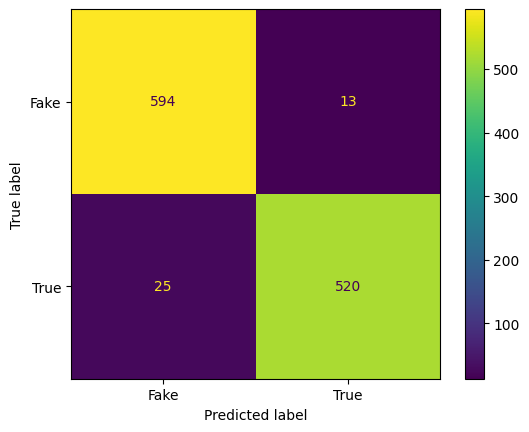

In [148]:
y_test_pred = lr_classifier.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
lr_classifier_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)
cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()



##### Multilayer perceptron (MLP)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       607
           1       0.96      0.90      0.93       545

    accuracy                           0.93      1152
   macro avg       0.94      0.93      0.93      1152
weighted avg       0.94      0.93      0.93      1152



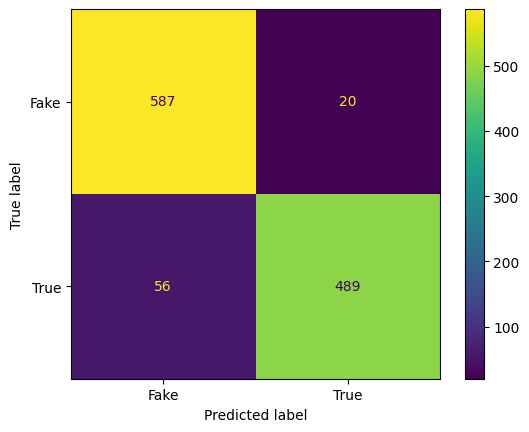

In [149]:
y_test_pred = mlp.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
mlp_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


##### Multilayer perceptron (MLP) Com GridSearchCV

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       607
           1       0.95      0.97      0.96       545

    accuracy                           0.96      1152
   macro avg       0.96      0.96      0.96      1152
weighted avg       0.96      0.96      0.96      1152



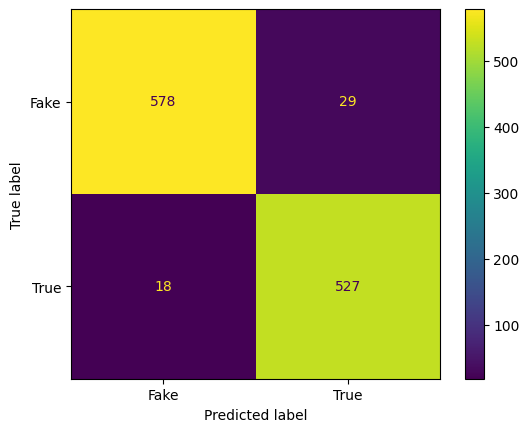

In [150]:

y_test_pred = mlpG.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
mlpG_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()

    

#### Decision Tree

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       607
           1       0.89      0.89      0.89       545

    accuracy                           0.90      1152
   macro avg       0.90      0.90      0.90      1152
weighted avg       0.90      0.90      0.90      1152



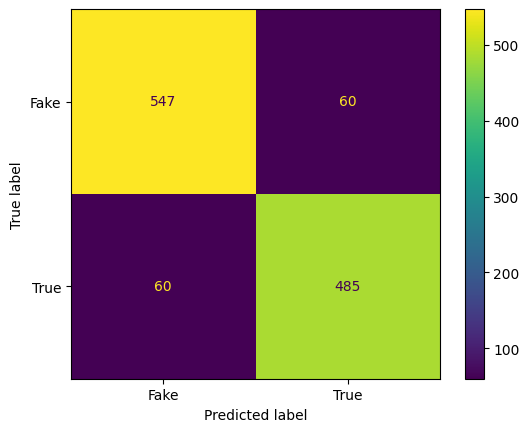

In [152]:
y_test_pred = decisionTree.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
decisionTree_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


#### Passive Aggressive

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       607
           1       0.89      0.89      0.89       545

    accuracy                           0.90      1152
   macro avg       0.90      0.90      0.90      1152
weighted avg       0.90      0.90      0.90      1152



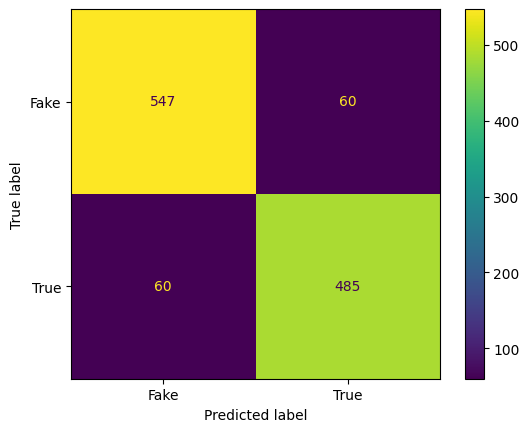

In [153]:
x_test_pred = passive.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
passive_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


#### RNN

36/36 [==============================] - 1s 38ms/step
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       607
           1       0.96      0.90      0.93       545

    accuracy                           0.94      1152
   macro avg       0.94      0.94      0.94      1152
weighted avg       0.94      0.94      0.94      1152



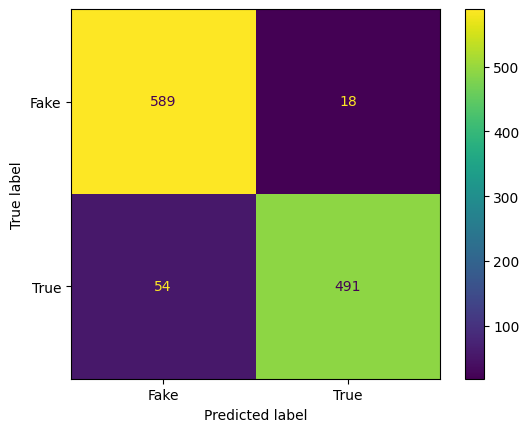

In [155]:

y_test_pred = rnn.predict(test_padded_seqeunces)
y_test_pred = (y_test_pred > 0.70)
rnn_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


### Comparando Modelos Diferentes

In [156]:
model = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Decision Tree',
        'MLPClassifier',
        'MLPClassifier with grid',
        'PassiveAggressiveClassifier',
        'RNN'
    ],
    'Training Accuracy': [
        lr_classifier_train, decisionTree_train,
        mlp_train,mlpG_train, passive_train,rnn_train
    ],
    'Model Accuracy Score': [
        lr_classifier_acc, decisionTree_acc,
        mlp_acc, mlpG_acc, passive_acc,rnn_acc
    ]
})

In [157]:
model = model.sort_values('Model Accuracy Score',ascending=False)
model

,Model,Training Accuracy,Model Accuracy Score
0,Logistic Regression,99.98,96.70
3,MLPClassifier with grid,100.00,95.92
5,RNN,87.17,93.75
2,MLPClassifier,100.00,93.40
1,Decision Tree,100.00,89.58
4,PassiveAggressiveClassifier,100.00,89.58
